In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

tf.keras.backend.clear_session()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2024-06-21 12:57:26.898638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2024-06-21 12:57:32.264059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 12:57:32.264426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 12:57:32.298273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
import numpy as np

df_aug = df_train.copy(deep=True)
df_aug['full_text'] = np.NaN

In [4]:
import pickle

with open('similar_words_dict.pkl', 'rb') as fp:
    similar_words_dict = pickle.load(fp)
    print('Similar words dict loaded')

Similar words dict loaded


In [5]:
from datetime import datetime
from multiprocessing import Pool

def augmented_text_with_glove(text):
    augmented_text = []
    for word in text.split():
        if word in similar_words_dict:
            augmented_text.append(similar_words_dict[word])
        else:
            augmented_text.append(word)
    return ' '.join(augmented_text)

def parallel_augment_texts(texts, num_workers=4):
    with Pool(num_workers) as pool:
        augmented_texts = list(pool.imap(augmented_text_with_glove, texts))
    return augmented_texts

print("Starting data augmentation now\n")
aug_start = datetime.now()
      
df_aug['full_text'] = parallel_augment_texts(df_train['full_text'].tolist())

aug_end = datetime.now()

print("Augmentation completed in: ", (aug_end - aug_start))

Starting data augmentation now

Augmentation completed in:  0:00:03.015116


In [6]:
df_train_fin = pd.concat([df_train, df_aug], axis=0)
len(df_train_fin)

34614

In [7]:
df_train_fin['score'] = df_train_fin['score'] - 1

In [8]:
df_train_fin['full_text'].map(len).mean()

2180.515253943491

In [9]:
df_train_fin.reset_index(drop=True, inplace=True)
df_train_fin.tail()

,essay_id,full_text,score
34609,ffd378d,of stories “ The Challenge the Exploing Venus ...,1
34610,ffddf1f,Technology have changing another really the wa...,3
34611,fff016d,If 'll don't such sit about those days more th...,1
34612,fffb49b,"In ""The Challenge the Exporing Venus,"" of nove...",0
34613,fffed3e,Venus now deserving places help studies though...,1


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

splits = sss(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in splits.split(df_train_fin['full_text'], df_train_fin['score']):
    X_train, X_test = df_train_fin['full_text'][train_index], df_train_fin['full_text'][test_index]
    y_train, y_test = df_train_fin['score'][train_index], df_train_fin['score'][test_index]

In [11]:
print("X_train:", X_train)
print("X_test:", X_test)
print("y_train:", y_train)
print("y_test:", y_test)

X_train: 19127    I personally, really but this could being anot...
24499    What could 'll n't not 'll been leaving where ...
13019    Why might spending time on a ship of animals b...
6717     The new technology called the Facial Action Co...
31175    Here these of reason know I really 'll must jo...
                               ...                        
19162    [M]Luck points the of views compelling other h...
28525    The Seagoing Cowboys programs now incredible b...
21947    Today we ever revolved about york cars, going ...
27152    ''Are 'll joking me, 'll something really but ...
26948    The roles another cars played where of lives t...
Name: full_text, Length: 27691, dtype: object
X_test: 11895    Venus is the second planet from our sun. Venus...
6747     In "The Challenge of Exploring Venus," the aut...
13188    In the passage, "Driverless Cars Are Coming", ...
31824    The novelist opposes of notion but studied Ven...
24040    In of 1950's of General Motors create of ad

In [12]:
!pip install --user spacy

In [13]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.4 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy
# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Function to apply lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

from concurrent.futures import ProcessPoolExecutor

def process_chunk(chunk):
    return chunk.apply(lemmatize_text)

def parallel_lemmatize(data, num_processes):
    chunks = np.array_split(data, num_processes)
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(process_chunk, chunks))
    return pd.concat(results, ignore_index=True)

print("\nApplying lemmatization now")
lem_start = datetime.now()
print("\nLemmatization start time is: ", lem_start)

num_processes = 8
X_train = parallel_lemmatize(X_train, num_processes)

lem_end = datetime.now()
print("\nLemmatization end time is: ", lem_end)
print("\nData lemmatization complete")


Applying lemmatization now

Lemmatization start time is:  2024-06-21 12:57:53.352326

Lemmatization end time is:  2024-06-21 13:01:42.435397

Data lemmatization complete


In [15]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

X_train_nn = X_train
y_train_nn = y_train
X_test_nn = X_test
y_test_nn = y_test

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=30000, analyzer='char', ngram_range=(2,5))
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test = tfidf_vectorizer.transform(X_test).toarray()

In [16]:
sub_df = pd.read_csv('test.csv')
sub_df.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [17]:
sub_text = sub_df['full_text'].tolist()
sub_X = tfidf_vectorizer.transform(sub_text).toarray()

In [18]:
print(f"Expected feature shape: {X_train.shape[1]}")
print(f"Sub_X feature shape: {sub_X.shape[1]}")

Expected feature shape: 30000
Sub_X feature shape: 30000


In [19]:
!pip install xgboost

  Using cached xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl (190.9 MB)


In [20]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(n_jobs=-1, device='cuda', grow_policy='lossguide', colsample_bytree=0.7, booster='gbtree', n_estimators=100, subsample=0.7)
xgb_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
xgb_preds = xgb_model.predict(X_test) + 1
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy}")

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:02:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:02:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.2484472049689441


In [22]:
sub_xgb_preds = xgb_model.predict(sub_X) + 1
print(sub_xgb_preds)

[3 3 4]


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, bootstrap=True)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test) + 1
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.2938032644807165


In [24]:
sub_rf_preds = rf_model.predict(sub_X) + 1
print(sub_rf_preds)

[3 3 4]


In [25]:
# import numpy as np

# X_train_reshaped = np.expand_dims(X_train, axis=-1)
# X_test_reshaped = np.expand_dims(X_test, axis=-1)

# print(X_train_reshaped.shape)
# print(X_test_reshaped.shape)

In [26]:
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [27]:
X_train_nn
labels = y_train_nn
X_test_nn
val_labels = y_test_nn

In [28]:
!pip install tokenizers

  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Using cached huggingface_hub-0.23.4-py3-none-any.whl (402 kB)


In [29]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers
# Initialize and train a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC(), normalizers.Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=400000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # vocab size increased 30/05/2024
tokenizer.train_from_iterator(X_train_nn, trainer)
tokenizer.save("tokenizer.json")

In [30]:
tokenizer = Tokenizer.from_file("tokenizer.json")
tokenized_texts = [tokenizer.encode(text).ids for text in X_train_nn]

In [31]:
val_tokenized_texts = [tokenizer.encode(val_text).ids for val_text in X_test_nn]

In [32]:
# Pad the tokenized texts
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 3000
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length, padding='post')

val_padded_texts = pad_sequences(val_tokenized_texts, maxlen=max_length, padding='post')

In [33]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_texts, labels))
dataset = dataset.shuffle(len(X_train_nn)).batch(256)

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded_texts, val_labels))
val_dataset = val_dataset.batch(256)

2024-06-21 13:05:49.947215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:05:49.947635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:05:49.947909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [34]:
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

nn_model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(max_length,)),
tf.keras.layers.Embedding(input_dim=400000, output_dim=128), 
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),    
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(6, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nn_model.summary()

2024-06-21 13:05:50.752703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-21 13:05:50.754949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-21 13:05:50.756373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 128)         51200000  
                                                                 
 conv1d (Conv1D)             (None, 2996, 128)         82048     
                                                                 
 dropout (Dropout)           (None, 2996, 128)         0         
                                                                 
 dense (Dense)               (None, 2996, 64)          8256      
                                                                 
 dropout_1 (Dropout)         (None, 2996, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 2996, 64)          4160      
                                                                 
 dropout_2 (Dropout)         (None, 2996, 64)          0

2024-06-21 13:05:51.517553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-21 13:05:51.519616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-21 13:05:51.521218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
history = nn_model.fit(dataset, epochs=40, validation_data=val_dataset) 

Epoch 1/40


2024-06-21 13:05:51.729991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [27691]
	 [[{{node Placeholder/_1}}]]
2024-06-21 13:05:51.730438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [27691]
	 [[{{node Placeholder/_1}}]]
2024-06-21 13:05:52.105302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

109/109 [==============================] - ETA: 0s - loss: 2.1707 - accuracy: 0.3590

2024-06-21 13:06:59.495790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [6923]
	 [[{{node Placeholder/_1}}]]
2024-06-21 13:06:59.831820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-21 13:06:59.834067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gr

109/109 [==============================] - 73s 571ms/step - loss: 2.1707 - accuracy: 0.3590 - val_loss: 1.6738 - val_accuracy: 0.3628
Epoch 2/40
109/109 [==============================] - 57s 519ms/step - loss: 1.4755 - accuracy: 0.3919 - val_loss: 1.4109 - val_accuracy: 0.3891
Epoch 3/40
109/109 [==============================] - 54s 493ms/step - loss: 1.2786 - accuracy: 0.4497 - val_loss: 1.2724 - val_accuracy: 0.4648
Epoch 4/40
109/109 [==============================] - 52s 480ms/step - loss: 1.0600 - accuracy: 0.5516 - val_loss: 1.0982 - val_accuracy: 0.5438
Epoch 5/40
109/109 [==============================] - 49s 454ms/step - loss: 0.9200 - accuracy: 0.6135 - val_loss: 1.1804 - val_accuracy: 0.4791
Epoch 6/40
109/109 [==============================] - 49s 448ms/step - loss: 0.8381 - accuracy: 0.6540 - val_loss: 1.2242 - val_accuracy: 0.4761
Epoch 7/40
109/109 [==============================] - 47s 432ms/step - loss: 0.7439 - accuracy: 0.7026 - val_loss: 1.2755 - val_accuracy: 0.4

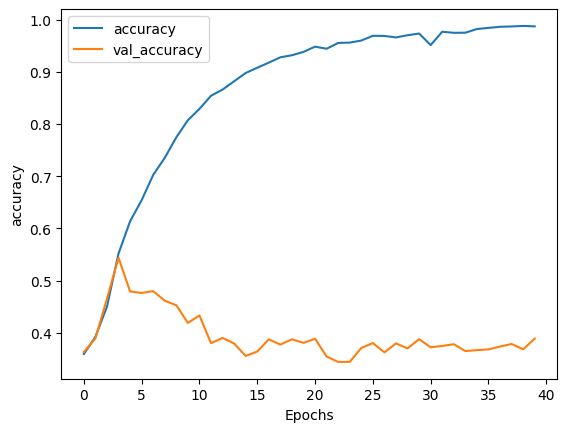

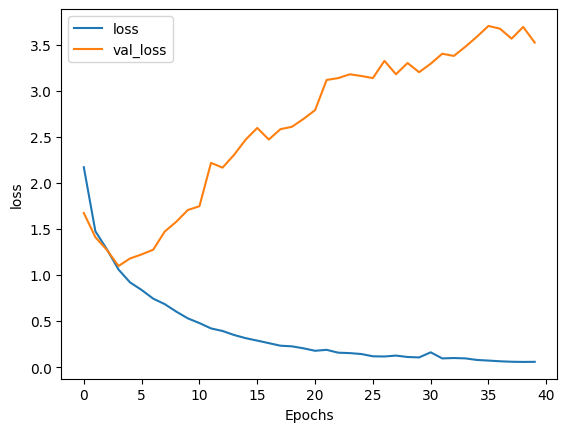

In [36]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
pred_texts = sub_df['full_text'].tolist()
tokenized_pred_texts = [tokenizer.encode(pred_text).ids for pred_text in pred_texts]
padded_pred_texts = pad_sequences(tokenized_pred_texts, maxlen=max_length, padding='post')
numpy_pred_texts = np.array(padded_pred_texts)

In [39]:
preds = nn_model.predict(numpy_pred_texts)
preds

2024-06-21 13:36:02.758871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-21 13:36:02.761058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-21 13:36:02.762764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


array([[1.155e-02, 6.348e-01, 3.206e-01, 3.235e-02, 7.095e-04, 3.040e-06],
       [5.960e-07, 7.451e-05, 9.990e-01, 9.103e-04, 5.543e-06, 5.960e-08],
       [9.924e-02, 1.740e-04, 4.238e-03, 7.147e-02, 8.179e-01, 6.901e-03]],
      dtype=float16)

In [40]:
max_preds = np.argmax(preds, axis=1)
res_lst = max_preds + 1
res_lst

array([2, 3, 5])

In [ ]:
# sub_nn_preds = nn_model.predict(sub_X_reshaped)
# sub_nn_pred_classes = sub_nn_preds.argmax(axis=1) + 1
# print(sub_nn_pred_classes)

In [ ]:
# import numpy as np
# from sklearn.linear_model import LogisticRegression

# stacked_predictions = np.column_stack((sub_xgb_preds, sub_rf_preds, sub_nn_pred_classes))

# meta_model = LogisticRegression()
# meta_model.fit(stacked_predictions, y_test)

# final_preds = meta_model.predict(stacked_predictions)
# final_accuracy = accuracy_score(y_test, final_preds)
# print(f"Stacked Model Accuracy: {final_accuracy}")

In [41]:
from scipy.stats import mode

combined_preds = np.array([sub_xgb_preds, sub_rf_preds, res_lst])
final_preds = mode(combined_preds, axis=0)[0].flatten()

final_preds

array([3, 3, 4])

In [42]:
df_sub_fin = pd.DataFrame()
df_sub_fin['essay_id'] = sub_df['essay_id']
df_sub_fin

,essay_id
0,000d118
1,000fe60
2,001ab80


In [43]:
df_sub_fin['score'] = final_preds.transpose()
df_sub_fin['score'] = df_sub_fin['score'].astype('int')
df_sub_fin

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [44]:
df_sub_fin.to_csv('submission.csv', header=True, index=False)

In [45]:
import gc

gc.collect()

4968